# GraphFrames  

Graphs are an interesting way to solve data problems because graph structures are a more intuitive approach to many classes of data problems.  

In this chapter, you will learn about:  
• Why use graphs?  
• Understanding the classic graph problem: the flights dataset  
• Understanding the graph vertices and edges  
• Simple queries  
• Using motif finding  
• Using breadth first search  
• Using PageRank  
• Visualizing flights using D3  

Whether traversing social networks or restaurant recommendations, it is easier to
understand these data problems within the context of graph structures: vertices,
edges, and properties.  

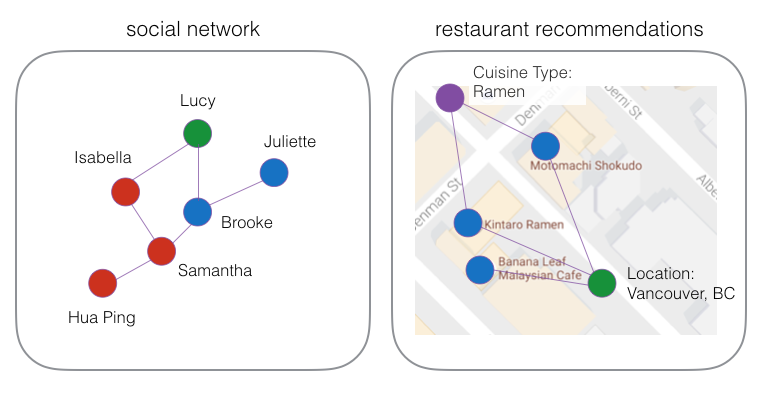  

For example, within the context of social networks, the vertices are the people
while the edges are the connections between them. Within the context of restaurant
recommendations, the vertices (for example) involve the location, cuisine type, and
restaurants while the edges are the connections between them (for example, these
three restaurants are in Vancouver, BC, but only two of them serve ramen).  

While the two graphs are seemingly disconnected, you can in fact create a social
network + restaurant recommendation graph based on the reviews of friends within
a social circle, as noted in the following figure:  

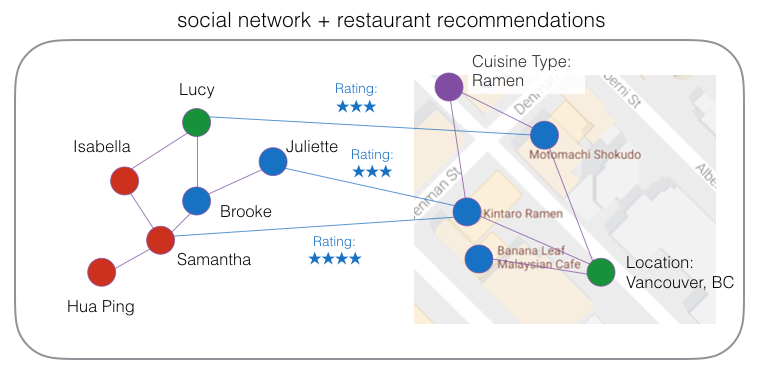  

For example, if Isabella wants to find a great ramen restaurant in Vancouver,
traversing her friends' reviews, she will most likely choose Kintaro Ramen, as
both Samantha and Juliette have rated the restaurant favorably:  

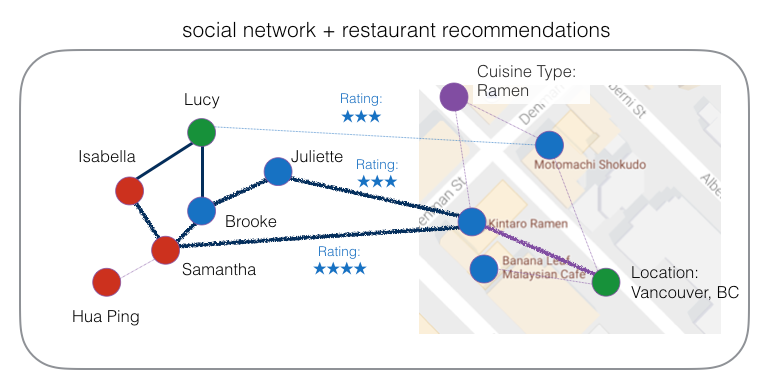  

Another classic graph problem is the analysis of flight data: airports are represented
by vertices and flights between those airports are represented by edges. Also, there
are numerous properties associated with these flights, including, but not limited to,
departure delays, plane type, and carrier:  

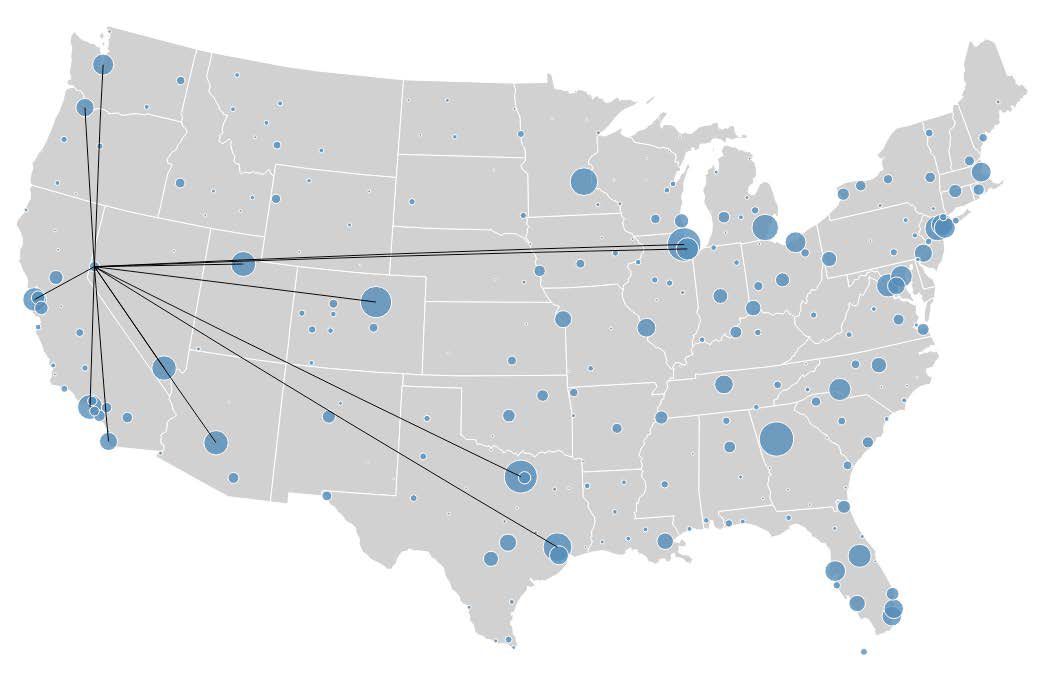  

In this chapter, we will use GraphFrames to quickly and easily analyze flight
performance data organized in graph structures. Because we're using graph
structures, we can easily ask many questions that are not as intuitive as tabular
structures, such as finding structural motifs, airport ranking using PageRank, and
shortest paths between cities. GraphFrames leverages the distribution and expression
capabilities of the DataFrame API to both simplify your queries and leverage the
performance optimizations of the Apache Spark SQL engine.  

In addition, with GraphFrames, graph analysis is available in Python, Scala, and
Java. Just as important, you can leverage your existing Apache Spark skills to solve
graph problems (in addition to machine learning, streaming, and SQL) instead of
making a paradigm shift to learn a new framework.

## Introducing GraphFrames  

GraphFrames utilizes the power of Apache Spark DataFrames to support general
graph processing. Specifically, the vertices and edges are represented by DataFrames
allowing us to store arbitrary data with each vertex and edge. While GraphFrames is
similar to Spark's GraphX library, there are some key differences, including:  
* GraphFrames leverage the performance optimizations and simplicity of the DataFrame API.  
* By using the DataFrame API, GraphFrames now have Python, Java, and Scala APIs. GraphX is only accessible through Scala; now all its algorithms are available in Python and Java.  


In [1]:
import os
import sys
from os.path import abspath
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
import pyspark.sql.types as typ
import findspark
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import pyspark.ml.feature as ft
import glob

In [2]:
os.environ["SPARK_HOME"] = "C:/Program Files/spark-3.5.4-bin-hadoop3"
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_431" 
os.environ['HADOOP_HOME '] = 'C:/Program Files/hadoop-3.4.0'

spark_python = os.path.join(os.environ.get('SPARK_HOME',None),'python')
py4j = glob.glob(os.path.join(spark_python,'lib','py4j-*.zip'))[0]
graphf = glob.glob(os.path.join(spark_python,'graphframes.zip'))[0]
sys.path[:0]=[spark_python,py4j]
sys.path[:0]=[spark_python,graphf]
os.environ['PYTHONPATH']=py4j+os.pathsep+graphf



In [3]:
import findspark
findspark.init()
findspark.find()

'C:/Program Files/spark-3.5.4-bin-hadoop3'

In [4]:
# Create a SparkSession

spark = SparkSession.builder.appName("GraphFrames for Apache Spark").getOrCreate()

sc = spark.sparkContext  # Accès au SparkContext à partir de SparkSession


In this example, we are creating two variables denoting the file paths for our Airports
and Departure Delays data, respectively. Then we will load these datasets and create
the respective Spark DataFrames; note for both of these files, we can easily infer
the schema:  

from gra

In [5]:

# Set File Paths
tripdelaysFilePath = "datasets/departuredelays.csv"
airportsnaFilePath = "datasets/airport-codes-na.txt"  

# Obtain airports dataset
airportsna = spark.read.csv(airportsnaFilePath, header='true', inferSchema='true', sep='\t')
airportsna.createOrReplaceTempView("airports_na") 

# Obtain departure Delays data
departureDelays = spark.read.csv(tripdelaysFilePath, header='true')
departureDelays.createOrReplaceTempView("departureDelays")
departureDelays.cache()

# Available IATA codes from the departuredelays sample dataset
tripIATA = spark.sql("select distinct iata from (select distinct origin as iata from departureDelays union all select distinct destination as iata from departureDelays) a")
tripIATA.createOrReplaceTempView("tripIATA")


# Only include airports with atleast one trip from the departureDelays dataset
airports = spark.sql("select f.IATA, f.City, f.State, f.Country from airports_na f join tripIATA t on t.IATA = f.IATA")
airports.createOrReplaceTempView("airports")
airports.cache()

DataFrame[IATA: string, City: string, State: string, Country: string]

Once we loaded the departureDelays DataFrame, we also cache it so we can
include some additional filtering of the data in a performant manner.  

The preceding query allows us to build a distinct list with origin city IATA codes
(for example, Seattle = 'SEA', San Francisco = 'SFO', New York JFK =
'JFK', and so on). Next, we only include airports that had a trip occur within the
departureDelays DataFrame.  




In [6]:
departureDelays.count()

1391578

By building the distinct list of origin airport codes, we can build the airports
DataFrame to contain only the airport codes that exist in the departureDelays
dataset. The following code snippet generates a new DataFrame (departureDelays_
geo) that is comprised of key attributes including date of flight, delays, distance, and
airport information (origin, destination):

In [7]:
# Build `departureDelays_geo` DataFrame
#  Obtain key attributes such as Date of flight, delays, distance, and airport information (Origin, Destination)  
departureDelays_geo = spark.sql("select cast(f.date as int) as tripid, cast(concat(concat(concat(concat(concat(concat('2014-', concat(concat(substr(cast(f.date as string), 1, 2), '-')), substr(cast(f.date as string), 3, 2)), ' '), substr(cast(f.date as string), 5, 2)), ':'), substr(cast(f.date as string), 7, 2)), ':00') as timestamp) as `localdate`, cast(f.delay as int), cast(f.distance as int), f.origin as src, f.destination as dst, o.city as city_src, d.city as city_dst, o.state as state_src, d.state as state_dst from departuredelays f join airports o on o.iata = f.origin join airports d on d.iata = f.destination") 

# Create Temporary View and cache
departureDelays_geo.createOrReplaceTempView("departureDelays_geo")
departureDelays_geo.cache()

# Count
departureDelays_geo.count()

1361141

To take a quick peek into this data, you can run the show method as shown here:  

In [8]:
# Review the top 10 rows of the `departureDelays_geo` DataFrame
departureDelays_geo.show(10)

+-------+-------------------+-----+--------+---+---+-----------+--------+---------+---------+
| tripid|          localdate|delay|distance|src|dst|   city_src|city_dst|state_src|state_dst|
+-------+-------------------+-----+--------+---+---+-----------+--------+---------+---------+
|1011335|2014-01-01 13:35:00|   -4|     389|MSY|DFW|New Orleans|  Dallas|       LA|       TX|
|1011550|2014-01-01 15:50:00|   -2|     389|MSY|DFW|New Orleans|  Dallas|       LA|       TX|
|1011845|2014-01-01 18:45:00|  -12|     586|MSY|MIA|New Orleans|   Miami|       LA|       FL|
|1010825|2014-01-01 08:25:00|   -1|     389|MSY|DFW|New Orleans|  Dallas|       LA|       TX|
|1011505|2014-01-01 15:05:00|   -4|     586|MSY|MIA|New Orleans|   Miami|       LA|       FL|
|1010650|2014-01-01 06:50:00|   -7|     389|MSY|DFW|New Orleans|  Dallas|       LA|       TX|
|1011010|2014-01-01 10:10:00|   -3|     389|MSY|DFW|New Orleans|  Dallas|       LA|       TX|
|1011910|2014-01-01 19:10:00|   19|     389|MSY|DFW|New Orle

## Building the graph  

Now that we've imported our data, let's build our graph. To do this, we're going to
build the structure for our vertices and edges. At the time of writing, GraphFrames
requires a specific naming convention for vertices and edges:  
* The column representing the vertices needs to have the name ofid. In our
case, the vertices of our flight data are the airports. Therefore, we will need
to rename the IATA airport code to id in our airports DataFrame.  
* The columns representing the edges need to have a source (src) and
destination (dst). For our flight data, the edges are the flights, therefore
the src and dst are the origin and destination columns from the
departureDelays_geo DataFrame.  


To simplify the edges for our graph, we will create the tripEdges DataFrame with
a subset of the columns available within the departureDelays_Geo DataFrame. As
well, we created a tripVertices DataFrame that simply renames the IATA column
to id to match the GraphFrame naming convention:

In [9]:
# Note, ensure you have already installed the GraphFrames spack-package
from pyspark.sql.functions import *
from graphframes import *

In [10]:
# Create Vertices (airports) and Edges (flights)
tripVertices = airports.withColumnRenamed("IATA", "id").distinct()
tripEdges = departureDelays_geo.select("tripid", "delay", "src", "dst", "city_dst", "state_dst")

# Cache Vertices and Edges
tripEdges.cache()
tripVertices.cache()

DataFrame[id: string, City: string, State: string, Country: string]

In [11]:
# Vertices
#   The vertices of our graph are the airports
#display(tripVertices)
# tripVertices.show(10)
tripEdges.show(5)

+-------+-----+---+---+--------+---------+
| tripid|delay|src|dst|city_dst|state_dst|
+-------+-----+---+---+--------+---------+
|1011335|   -4|MSY|DFW|  Dallas|       TX|
|1011550|   -2|MSY|DFW|  Dallas|       TX|
|1011845|  -12|MSY|MIA|   Miami|       FL|
|1010825|   -1|MSY|DFW|  Dallas|       TX|
|1011505|   -4|MSY|MIA|   Miami|       FL|
+-------+-----+---+---+--------+---------+
only showing top 5 rows



Now that we have the two DataFrames, we can create a GraphFrame using the
GraphFrame command:

In [12]:
# Build `tripGraph` GraphFrame
#  This GraphFrame builds up on the vertices and edges based on our trips (flights)
tripGraph = GraphFrame(tripVertices, tripEdges)
print(tripGraph)

GraphFrame(v:[id: string, City: string ... 2 more fields], e:[src: string, dst: string ... 4 more fields])


c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


### Executing simple queries  

Let's start with a set of simple graph queries to understand flight performance and
departure delays.

* **Determining the number of airports and trips**  

For example, to determine the number of airports and trips, you can run the
following commands:

In [17]:
print("Airports: %d" % tripGraph.vertices.count())
print("Trips: %d" % tripGraph.edges.count())

Airports: 279
Trips: 1361141


As you can see from the results, there are 279 airports with 1.36 million trips:

* **Determining the longest delay in this dataset**  
To determine the longest delayed flight in the dataset, you can run the following
query

In [18]:
tripGraph.edges.groupBy().max("delay").show()

+----------+
|max(delay)|
+----------+
|      1642|
+----------+



In [19]:
longestDelay = tripGraph.edges.groupBy().max("delay")

the result of 1,642 minutes (that's more than 27 hours!)

* **Determining the number of delayed versus on-time/early flights**  
To determine the number of delayed versus on-time (or early) flights, you can run
the following queries:


In [20]:
# Determining number of on-time / early flights vs. delayed flights
print("On-time / Early Flights: %d" % tripGraph.edges.filter("delay <= 0").count())
print("Delayed Flights: %d" % tripGraph.edges.filter("delay > 0").count())

On-time / Early Flights: 780469
Delayed Flights: 580672


with the results nothing that almost 43% of the flights were delayed!

* **What flights departing Seattle are most likely to have significant delays?**  

Digging further in this data, let's find out the top five destinations for flights
departing from Seattle that are most likely to have significant delays. This can be
achieved through the following query:

Note, delay can be <= 0 meaning the flight left on time or early 

In [21]:
tripGraph.edges.filter("src = 'SEA' and delay > 0"
                ).groupBy("src", "dst"
                ).avg("delay"
                ).sort(desc("avg(delay)")
                ).show(5)

+---+---+------------------+
|src|dst|        avg(delay)|
+---+---+------------------+
|SEA|PHL|55.666666666666664|
|SEA|COS| 43.53846153846154|
|SEA|FAT| 43.03846153846154|
|SEA|LGB| 39.39705882352941|
|SEA|IAD|37.733333333333334|
+---+---+------------------+
only showing top 5 rows



As you can see in the following results: Philadelphia (PHL), Colorado Springs (COS),
Fresno (FAT), Long Beach (LGB), and Washington D.C (IAD) are the top five cities
with flights delayed originating from Seattle.

* **What states tend to have significant delays departing from Seattle?**  

Let's find which states have the longest cumulative delays (with individual delays >
100 minutes) originating from Seattle.

In [26]:
# States with the longest cumulative delays (with individual
# delays > 100 minutes) (origin: Seattle)
from IPython.display import display

# display(tripGraph.edges.filter("src = 'SEA' and delay > 100"))

tripGraph.edges.filter("src = 'SEA' and delay > 100").show()

+-------+-----+---+---+------------+---------+
| tripid|delay|src|dst|    city_dst|state_dst|
+-------+-----+---+---+------------+---------+
|1021425|  298|SEA|ORD|     Chicago|       IL|
|1030600|  103|SEA|ORD|     Chicago|       IL|
|1060830|  116|SEA|DFW|      Dallas|       TX|
|1081205|  135|SEA|ORD|     Chicago|       IL|
|1112205|  101|SEA|MIA|       Miami|       FL|
|1161205|  582|SEA|ORD|     Chicago|       IL|
|1180830|  132|SEA|DFW|      Dallas|       TX|
|1241205|  174|SEA|ORD|     Chicago|       IL|
|1262205|  130|SEA|MIA|       Miami|       FL|
|1281350|  115|SEA|DFW|      Dallas|       TX|
|1291545|  247|SEA|DFW|      Dallas|       TX|
|1300815|  209|SEA|ORD|     Chicago|       IL|
|1012140|  136|SEA|SMF|  Sacramento|       CA|
|1010715|  164|SEA|SMF|  Sacramento|       CA|
|1021235|  113|SEA|ORD|     Chicago|       IL|
|1020830|  151|SEA|ORD|     Chicago|       IL|
|1030845|  342|SEA|PHL|Philadelphia|       PA|
|1032115|  196|SEA|LAS|   Las Vegas|       NV|
|1040955|  12

#### Understanding vertex degrees  
Within the context of graph theory, the degrees around a vertex are the number
of edges around the vertex. In our flights example, the degrees are then the total
number of edges (that is, flights) to the vertex (that is, airports). Therefore, if we were
to obtain the top 20 vertex degrees (in descending order) from our graph, then we
would be asking for the top 20 busiest airports (most flights in and out) from our
graph. This can be quickly determined using the following query: 

In [28]:
# display(tripGraph.degrees.sort(desc("degree")).limit(20))

tripGraph.degrees.sort(desc("degree")).limit(20).show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+------+
| id|degree|
+---+------+
|ATL|179774|
|DFW|133966|
|ORD|125405|
|LAX|106853|
|DEN|103699|
|IAH| 85685|
|PHX| 79672|
|SFO| 77635|
|LAS| 66101|
|CLT| 56103|
|EWR| 54407|
|MCO| 54300|
|LGA| 50927|
|SLC| 50780|
|BOS| 49936|
|DTW| 46705|
|MSP| 46235|
|SEA| 45816|
|JFK| 43661|
|BWI| 42526|
+---+------+



Diving into more details, here are the top 20 inDegrees (that is, incoming flights):

In [29]:
# display(tripGraph.inDegrees.sort(desc("inDegree")).limit(20))
tripGraph.inDegrees.sort(desc("inDegree")).limit(20).show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+--------+
| id|inDegree|
+---+--------+
|ATL|   89633|
|DFW|   65767|
|ORD|   61654|
|LAX|   53184|
|DEN|   50738|
|IAH|   42512|
|PHX|   39619|
|SFO|   38641|
|LAS|   32994|
|CLT|   28044|
|EWR|   27201|
|MCO|   27071|
|LGA|   25469|
|SLC|   25169|
|BOS|   24973|
|DTW|   23297|
|SEA|   22906|
|MSP|   22372|
|JFK|   21832|
|BWI|   21262|
+---+--------+



While here are the top 20 outDegrees (that is, outgoing flights):

In [30]:
# display(tripGraph.outDegrees.sort(desc("outDegree")).limit(20))
tripGraph.outDegrees.sort(desc("outDegree")).limit(20).show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+---------+
| id|outDegree|
+---+---------+
|ATL|    90141|
|DFW|    68199|
|ORD|    63751|
|LAX|    53669|
|DEN|    52961|
|IAH|    43173|
|PHX|    40053|
|SFO|    38994|
|LAS|    33107|
|CLT|    28059|
|MCO|    27229|
|EWR|    27206|
|SLC|    25611|
|LGA|    25458|
|BOS|    24963|
|MSP|    23863|
|DTW|    23408|
|SEA|    22910|
|JFK|    21829|
|BWI|    21264|
+---+---------+



Interestingly, while the top 10 airports (Atlanta/ATL to Charlotte/CLT) are ranked
the same for incoming and outgoing flights, the ranks of the next 10 airports change
(for example, Seattle/SEA is 17th for incoming flights, but 18th for outgoing).

* **Determining the top transfer airports**  

An extension of understanding vertex degrees for airports is to determine the top
transfer airports. Many airports are used as transfer points instead of being the final
destination. An easy way to calculate this is by calculating the ratio of inDegrees
(the number of flights to the airport) and / outDegrees (the number of flights
leaving the airport). Values close to 1 may indicate many transfers, whereas values
<1 indicate many outgoing flights and values >1 indicate many incoming flights.

Note that this is a simple calculation that does not consider timing or scheduling of
flights, just the overall aggregate number within the dataset:

* inDegrees: Incoming connections to the airport  
* outDegrees: Outgoing connections from the airport  
* degrees: Total connections to and from the airport  

In [31]:
# Degrees
#  The number of degrees - the number of incoming and outgoing connections - for various airports within this sample dataset
# display(tripGraph.degrees.sort(desc("degree")).limit(20))
tripGraph.degrees.sort(desc("degree")).limit(20).show()


c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+------+
| id|degree|
+---+------+
|ATL|179774|
|DFW|133966|
|ORD|125405|
|LAX|106853|
|DEN|103699|
|IAH| 85685|
|PHX| 79672|
|SFO| 77635|
|LAS| 66101|
|CLT| 56103|
|EWR| 54407|
|MCO| 54300|
|LGA| 50927|
|SLC| 50780|
|BOS| 49936|
|DTW| 46705|
|MSP| 46235|
|SEA| 45816|
|JFK| 43661|
|BWI| 42526|
+---+------+



In [32]:
# inDegrees
#  The number of degrees - the number of incoming connections - for various airports within this sample dataset
# display(tripGraph.inDegrees.sort(desc("inDegree")).limit(20))

tripGraph.inDegrees.sort(desc("inDegree")).limit(20).show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+--------+
| id|inDegree|
+---+--------+
|ATL|   89633|
|DFW|   65767|
|ORD|   61654|
|LAX|   53184|
|DEN|   50738|
|IAH|   42512|
|PHX|   39619|
|SFO|   38641|
|LAS|   32994|
|CLT|   28044|
|EWR|   27201|
|MCO|   27071|
|LGA|   25469|
|SLC|   25169|
|BOS|   24973|
|DTW|   23297|
|SEA|   22906|
|MSP|   22372|
|JFK|   21832|
|BWI|   21262|
+---+--------+



In [33]:
# outDegrees
#  The number of degrees - the number of outgoing connections - for various airports within this sample dataset
# display(tripGraph.outDegrees.sort(desc("outDegree")).limit(20))
tripGraph.outDegrees.sort(desc("outDegree")).limit(20).show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+---------+
| id|outDegree|
+---+---------+
|ATL|    90141|
|DFW|    68199|
|ORD|    63751|
|LAX|    53669|
|DEN|    52961|
|IAH|    43173|
|PHX|    40053|
|SFO|    38994|
|LAS|    33107|
|CLT|    28059|
|MCO|    27229|
|EWR|    27206|
|SLC|    25611|
|LGA|    25458|
|BOS|    24963|
|MSP|    23863|
|DTW|    23408|
|SEA|    22910|
|JFK|    21829|
|BWI|    21264|
+---+---------+



In [34]:
# Calculate the inDeg (flights into the airport) and
# outDeg (flights leaving the airport)
inDeg = tripGraph.inDegrees
outDeg = tripGraph.outDegrees
# Calculate the degreeRatio (inDeg/outDeg)
degreeRatio = inDeg.join(outDeg, inDeg.id == outDeg.id) \
.drop(outDeg.id) \
.selectExpr("id", "double(inDegree)/double(outDegree) as degreeRatio") \
.cache()

# Join back to the 'airports' DataFrame
# (instead of registering temp table as above)

transferAirports = degreeRatio.join(airports, degreeRatio.id ==
airports.IATA) \
.selectExpr("id", "city", "degreeRatio") \
.filter("degreeRatio between 0.9 and 1.1")
# List out the top 10 transfer city airports
transferAirports.orderBy("degreeRatio").limit(10).show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+--------------+------------------+
| id|          city|       degreeRatio|
+---+--------------+------------------+
|MSP|   Minneapolis|0.9375183338222353|
|DEN|        Denver| 0.958025717037065|
|DFW|        Dallas| 0.964339653074092|
|ORD|       Chicago|0.9671063983310065|
|SLC|Salt Lake City|0.9827417906368358|
|IAH|       Houston|0.9846895050147083|
|PHX|       Phoenix|0.9891643572266746|
|OGG| Kahului, Maui|0.9898718478710211|
|HNL|Honolulu, Oahu| 0.990535889872173|
|SFO| San Francisco|0.9909473252295224|
+---+--------------+------------------+



This makes sense since these airports are major hubs for national airlines (for
example, Delta uses Minneapolis and Salt Lake City as its hub, Frontier uses
Denver, American uses Dallas and Phoenix, United uses Houston, Chicago, and
San Francisco, and Hawaiian Airlines uses Kahului and Honolulu as its hubs).

#### Understanding motifs  

To easily understand the complex relationship of city airports and the flights
between each other, we can use motifs to find patterns of airports (for example,
vertices) connected by flights (that is, edges). The result is a DataFrame in which the
column names are given by the motif keys. Note that motif finding is one of the new
graph algorithms supported as part of GraphFrames.  

For example, let's determine the delays that are due to San Francisco International
Airport (SFO):

In [41]:
# Using tripGraphPrime to more easily display 
#   - The associated edge (ab, bc) relationships 
#   - With the different the city / airports (a, b, c) where SFO is the connecting city (b)
#   - Ensuring that flight ab (i.e. the flight to SFO) occured before flight bc (i.e. flight leaving SFO)
#   - Note, TripID was generated based on time in the format of MMDDHHMM converted to int
#       - Therefore bc.tripid < ab.tripid + 10000 means the second flight (bc) occured within approx a day of the first flight (ab)
# Note: In reality, we would need to be more careful to link trips ab and bc.

# Build `tripGraphPrime` GraphFrame
#   This graphframe contains a smaller subset of data to make it easier to display motifs and subgraphs (below)
tripEdgesPrime = departureDelays_geo.select("tripid", "delay", "src", "dst")
tripGraphPrime = GraphFrame(tripVertices, tripEdgesPrime)

motifs = tripGraphPrime.find("(a)-[ab]->(b); (b)-[bc]->(c)")\
  .filter("(b.id = 'SFO') and (ab.delay > 500 or bc.delay > 500) and bc.tripid > ab.tripid and bc.tripid < ab.tripid + 10000")
display(motifs)

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


DataFrame[a: struct<id:string,City:string,State:string,Country:string>, ab: struct<tripid:int,delay:int,src:string,dst:string>, b: struct<id:string,City:string,State:string,Country:string>, bc: struct<tripid:int,delay:int,src:string,dst:string>, c: struct<id:string,City:string,State:string,Country:string>]

In [42]:
motifs.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   a|                  ab|                   b|                  bc|                   c|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|{MSY, New Orleans...|{1011751, -4, MSY...|{SFO, San Francis...|{1021507, 536, SF...|{JFK, New York, N...|
|{MSY, New Orleans...|{1201725, 2, MSY,...|{SFO, San Francis...|{1211508, 593, SF...|{JFK, New York, N...|
|{MSY, New Orleans...|{2091725, 87, MSY...|{SFO, San Francis...|{2092230, 636, SF...|{JFK, New York, N...|
|{MSY, New Orleans...|{2091725, 87, MSY...|{SFO, San Francis...|{2092110, 740, SF...|{MIA, Miami, FL, ...|
|{MSY, New Orleans...|{2121725, 15, MSY...|{SFO, San Francis...|{2131420, 504, SF...|{SAN, San Diego, ...|
|{BUR, Burbank, CA...|{1011828, 88, BUR...|{SFO, San Francis...|{1021507, 536, SF...|{JFK, New York, N...|
|{BUR, Burbank, CA...|{1020941, -17, 

Breaking down the preceding query, the (x) represents the vertex (that is, airport) while the [xy] represents the edge (that is, flights between airports). Therefore, to determine the delays that are due to SFO, use the following:  
• The vertex (b) represents the airport in the middle (that is, SFO)  
• The vertex(a)represents the origin airport (within the dataset)  
• The vertex (c) represents the destination airport (within the dataset)  
• The edge [ab] represents the flight between (a) (that is, origin) and (b) (that is, SFO)  
• The edge [bc] represents the flight between (b) (that is, SFO) and (c) (that is, destination)  

Within the filter statement, we put in some rudimentary constraints (note that this
is an over simplistic representation of flight paths):  
b.id = 'SFO' denotes that the middle vertex (b) is limited to just SFO airport  
• (ab.delay > 500 or bc.delay > 500) denotes that we are limited to flights that have delays greater than 500 minutes  
• (bc.tripid > ab.tripid and bc.tripid < ab.tripid + 10000) denotes that the (ab) flight must be before the (bc) trip and within thesame day. The tripid was derived from the date time, thus explaining why it could be simplified this way


Referring to the TUS > SFO > JFK flight, you will notice that while the flight from
Tuscon to San Francisco departed 5 minutes early, the flight from San Francisco to
New York JFK was delayed by 536 minutes.

By using motif finding, you can easily search for structural patterns in your graph;
by using GraphFrames, you are using the power and speed of DataFrames to
distribute and perform your query.

## Determining airport ranking using PageRank

Because GraphFrames is built on top of GraphX, there are several algorithms that we
can immediately leverage. PageRank was popularized by the Google Search Engine
and created by Larry Page. To quote Wikipedia:  

*"PageRank works by counting the number and quality of links to a page to
determine a rough estimate of how important the website is. The underlying
assumption is that more important websites are likely to receive more links from
other websites."*

While the preceding example refers to web pages, this concept readily applies to
any graph structure whether it is created from web pages, bike stations, or airports.
Yet the interface via GraphFrames is as simple as calling a method. GraphFrames.
PageRank will return the PageRank results as a new column appended to the vertices
DataFrame to simplify our downstream analysis.

As there are many flights and connections through the various airports included in
this dataset, we can use the PageRank algorithm to have Spark traverse the graph
iteratively to compute a rough estimate of how important each airport is:  

In [43]:
# Determining Airport ranking of importance using `pageRank`
ranks = tripGraph.pageRank(resetProbability=0.15, maxIter=5)

display(ranks.vertices.orderBy(ranks.vertices.pagerank.desc()).limit(10).show())


c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+---+--------------+-----+-------+------------------+
| id|          City|State|Country|          pagerank|
+---+--------------+-----+-------+------------------+
|ATL|       Atlanta|   GA|    USA|18.910104616739282|
|DFW|        Dallas|   TX|    USA|13.699227467380515|
|ORD|       Chicago|   IL|    USA|13.163049993794413|
|DEN|        Denver|   CO|    USA|  9.72338828381326|
|LAX|   Los Angeles|   CA|    USA| 8.703656827807508|
|IAH|       Houston|   TX|    USA| 7.991324463091616|
|SFO| San Francisco|   CA|    USA| 6.903242998287413|
|PHX|       Phoenix|   AZ|    USA| 6.505886984497275|
|SLC|Salt Lake City|   UT|    USA| 5.799587684561081|
|LAS|     Las Vegas|   NV|    USA| 5.253592445607843|
+---+--------------+-----+-------+------------------+



None

Note that resetProbability = 0.15 represents the probability of resetting to
a random vertex (this is the default value) while maxIter = 5 is a set number
of iterations.

In terms of airport ranking, the PageRank algorithm has determined that ATL
(Hartsfield-Jackson Atlanta International Airport) is the most important airport in
the United States. This observation makes sense as ATL is not only the busiest airport
in the United States (http://bit.ly/2eTGHs4), but it is also the busiest airport in
the world (2000-2015) (http://bit.ly/2eTGDsy).

* **Determining the most popular non-stop flights**  

Expanding upon our tripGraph GraphFrame, the following query will allow us to
find the most popular non-stop flights in the US (for this dataset):

In [44]:
# Determine the most popular flights (single city hops)
import pyspark.sql.functions as func
topTrips = tripGraph.edges.groupBy("src", "dst").agg(func.count("delay").alias("trips"))

# Show the top 20 most popular flights (single city hops)
topTrips.orderBy(topTrips.trips.desc()).limit(10).show()

+---+---+-----+
|src|dst|trips|
+---+---+-----+
|SFO|LAX| 3232|
|LAX|SFO| 3198|
|LAS|LAX| 3016|
|LAX|LAS| 2964|
|JFK|LAX| 2720|
|LAX|JFK| 2719|
|ATL|LGA| 2501|
|LGA|ATL| 2500|
|LAX|PHX| 2394|
|PHX|LAX| 2387|
+---+---+-----+



Note, while we are using the delay column, we're just actually doing a count of the
number of trips.

As can be observed from this query, the two most frequent non-stop flights are
between LAX (Los Angeles) and SFO (San Francisco). The fact that these flights are
so frequent indicates their importance in the airline market. As noted in the New
York Times article from April 4, 2016, Alaska Air Sees Virgin America as Key to West
Coast (http://nyti.ms/2ea1uZR), acquiring slots at these two airports was one of
the reasons why Alaska Airlines purchased Virgin Airlines. Graphs are not just fun
but also contain potentially powerful business insight!

### Using Breadth-First Search  

The Breadth-first search (BFS) is a new algorithm as part of GraphFrames that finds
the shortest path from one set of vertices to another. In this section, we will use BFS
to traverse our tripGraph to quickly find the desired vertices (that is, airports) and
edges (that is, flights). Let's try to find the shortest number of connections between
cities based on the dataset. Note that these examples do not consider time or
distance, just hops between cities. For example, to find the number of direct
flights between Seattle and San Francisco, you can run the following query:

In [45]:
filteredPaths = tripGraph.bfs(
  fromExpr = "id = 'SEA'",
  toExpr = "id = 'SFO'",
  maxPathLength = 1)

filteredPaths.show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------------------+--------------------+--------------------+
|                from|                  e0|                  to|
+--------------------+--------------------+--------------------+
|{SEA, Seattle, WA...|{1010710, 31, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1012125, -4, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1011840, -5, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1010610, -4, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1011230, -2, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1010955, -6, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1011100, 2, SEA,...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1011405, 0, SEA,...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1020710, -1, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1022125, -4, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1021840, -5, SEA...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{1020610, 3, SEA,...|{SFO, San Francis...|
|{SEA, Seattle, WA...|{10

fromExpr and toExpr are the expressions indicating the origin and destination
airports (that is, SEA and SFO, respectively). The maxPathLength = 1 indicates that
we only want one edge between the two vertices, that is, a non-stop flight between
Seattle and San Francisco. As noted in the output results, there are many direct
flights between Seattle and San Francisco:

But how about if we want to determine the number of direct flights between San
Francisco and Buffalo? Running the following query will note that there are no
results, that is, no direct flights between the two cities:

In [46]:
# Obtain list of direct flights between SFO and BUF
filteredPaths = tripGraph.bfs(
    fromExpr = "id = 'SFO'",
    toExpr = "id = 'BUF'",
    maxPathLength = 1)

# display list of direct flights
filteredPaths.show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+----+-----+-------+
| id|City|State|Country|
+---+----+-----+-------+
+---+----+-----+-------+



Once we modify the preceding query to maxPathLength = 2, that is, one layover,
then you will see a lot more flight options:

In [47]:
# display list of one-stop flights between SFO and BUF
filteredPaths = tripGraph.bfs(
    fromExpr = "id = 'SFO'",
    toExpr = "id = 'BUF'",
    maxPathLength = 2)
# display list of flights
filteredPaths.show()

c:\Users\balde\OneDrive\Bureau\TO DO\DE\Learning_PySpark\spark_envi\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------------------+--------------------+--------------------+--------------------+--------------------+
|                from|                  e0|                  v1|                  e1|                  to|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|{SFO, San Francis...|{3312300, 9, SFO,...|{BOS, Boston, MA,...|{1010635, -6, BOS...|{BUF, Buffalo, NY...|
|{SFO, San Francis...|{3310920, 16, SFO...|{BOS, Boston, MA,...|{1010635, -6, BOS...|{BUF, Buffalo, NY...|
|{SFO, San Francis...|{3302300, 0, SFO,...|{BOS, Boston, MA,...|{1010635, -6, BOS...|{BUF, Buffalo, NY...|
|{SFO, San Francis...|{3300920, -3, SFO...|{BOS, Boston, MA,...|{1010635, -6, BOS...|{BUF, Buffalo, NY...|
|{SFO, San Francis...|{3290920, -3, SFO...|{BOS, Boston, MA,...|{1010635, -6, BOS...|{BUF, Buffalo, NY...|
|{SFO, San Francis...|{3282300, 0, SFO,...|{BOS, Boston, MA,...|{1010635, -6, BOS...|{BUF, Buffalo, NY...|
|{SFO, San Francis...|{3280920, 0, SF

But now that I have my list of airports, how can I determine which layover airports
are more popular between SFO and BUF? To determine this, you can now run
the following query:

In [48]:
# Display most popular layover cities by descending count
filteredPaths.groupBy("v1.id", "v1.City").count().orderBy(desc("count")).limit(10).show()

+---+---------------+-------+
| id|           City|  count|
+---+---------------+-------+
|JFK|       New York|1233728|
|ORD|        Chicago|1088283|
|ATL|        Atlanta| 285383|
|LAS|      Las Vegas| 275091|
|BOS|         Boston| 238576|
|CLT|      Charlotte| 143444|
|PHX|        Phoenix| 104580|
|FLL|Fort Lauderdale|  96317|
|EWR|         Newark|  95370|
|MCO|        Orlando|  88615|
+---+---------------+-------+



## Summary
As you can see in this chapter, you can easily perform a lot of powerful data analysis
by executing queries against graph structures. With GraphFrames, you can leverage
the power, simplicity, and performance of the DataFrame API against your graph
problems.  

In the next chapter, we will expand our PySpark horizon into the area of Deep
Learning with the focus on TensorFlow and TensorFrames.